# Small scale testing with manually checked files

The goal for this small scale experiment is to ensure that we can train and validate the ML model using existing manually checked files as the foundation for the larger data set later and generate results.

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib2 import Path
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
import librosa
from librosa import load
import librosa.display
import spafe
from scipy import signal

In [2]:
#audio augmentation: to prevent over fitting by using shifting method
def audio_augment(arr, window_size = None, augment_ratio = 10):
    if window_size is None:
        window_size = arr.shape[-1] // augment_ratio

    if arr.ndim > 1:
        arr_augment = [arr[:, i:i+window_size] for i in np.linspace(0, arr.shape[-1] - window_size, augment_ratio).astype(int)]
        arr_augment = np.swapaxes(np.array(arr_augment), 0, 1)
        arr_augment = arr_augment.reshape(-1, window_size)
    elif arr.ndim == 1:
        arr_augment = np.array([arr[i:i+window_size] for i in np.linspace(0, arr.shape[-1] - window_size, augment_ratio).astype(int)])
    return arr_augment

In [3]:
#auto threshold function
def get_best_threshold(y_score, y_true):
    if len(np.unique(y_score)) == 1:
        return (np.unique(y_score)[0], 'low_NG')
    sorted_score = np.sort(np.unique(y_score))
    proposed_threshold = np.stack([np.roll(sorted_score, 1),
                                   sorted_score])[:, 1:].mean(axis = 0)
    max_f1score = -np.inf
    for threshold in proposed_threshold:
        low_decision_dict = {'score_threshold': threshold,
                             'rule': 'low_NG'}
        high_decision_dict = {'score_threshold': threshold,
                              'rule': 'high_NG'}
        y_pred_low = score_to_pred(y_score, low_decision_dict)
        y_pred_high = score_to_pred(y_score, high_decision_dict)
        f1score_low = f1_score(y_true, y_pred_low)
        f1score_high = f1_score(y_true, y_pred_high)
        if f1score_low > max_f1score:
            decision_dict = low_decision_dict
            max_f1score = f1score_low
        if f1score_high > max_f1score:
            decision_dict = high_decision_dict
            max_f1score = f1score_high
    return decision_dict

In [4]:
def score_to_pred(y_score, decision_dict):
    if decision_dict['rule'] == 'low_NG':
        threshold_low = decision_dict['score_threshold']
        threshold_high = y_score.max()
    elif decision_dict['rule'] == 'high_NG':
        threshold_low = y_score.min()
        threshold_high = decision_dict['score_threshold']
    y_pred = (y_score < threshold_low) | (y_score > threshold_high)
    return y_pred.astype(int)

In [5]:
#load files path
def load_wave(file_path, sr = None):
    return load(file_path, sr = sr)

In [6]:
#define data loading function
def load_data(data_dir, sr = None):
    data_dir = Path(data_dir)
    wave_path_list = list(data_dir.glob('**/*.wav'))
    #wave_path_list = unify_list(wave_path_list)  
    wave_list = []
    for wave_path in wave_path_list:
        y, sr = load_wave(str(wave_path), sr = sr)
        wave_list.append(y)
    wave = np.array(wave_list)
    return wave, sr

In [7]:
#Define feature extraction function using mfcc
def mfcc(arr, fs, n_mfcc = 20):
    arr_mfcc = []
    for i in range(len(arr)):
        S = librosa.feature.mfcc(arr[i], fs, n_mfcc = n_mfcc) 
        arr_mfcc.append(S)
    return np.array(arr_mfcc)

In [8]:
#read data from manually checked files
work_dir = Path('.')

#audio testing results that are pre-tested manually as "pass" status
ok_data_dir = work_dir / 'data/small_scale/OK'
#audio testing results that are pre-tested manually as "fail" status
ng_data_dir = work_dir / 'data/small_scale/NG'
#audio testing results that are pre-tested manually as "false-positive" status
fp_data_dir = work_dir / 'data/small_scale/FP'

ok_wave, sr = load_data(ok_data_dir)
ng_wave, sr = load_data(ng_data_dir)
fp_wave, sr = load_data(fp_data_dir)

In [9]:
#allocate data to train and validate
train_wave = ok_wave[:20]
valid_wave = np.concatenate([ok_wave[20:], ng_wave, fp_wave])

In [10]:
#set the parameters
augment_ratio = 10
n_mfcc = 40

#training and augmentation
window_train_wave = audio_augment(train_wave, sr, augment_ratio = augment_ratio)

#extract data
window_train_feature = mfcc(window_train_wave, sr, n_mfcc = n_mfcc).max(axis=-1)

In [20]:
#train model using GMM
model = GaussianMixture(n_components=1, covariance_type='full')
model.fit(window_train_feature)

GaussianMixture()

In [12]:
#audio augmentation
window_valid_wave = audio_augment(valid_wave, sr, augment_ratio = augment_ratio)

#extract data
window_valid_feature = mfcc(window_valid_wave, sr, n_mfcc = n_mfcc).max(axis=-1)

#Inference
#compute the log-likelihood of each sample - a way to measure the goodness of fit for a OK and NG model
window_score = model.score_samples(window_valid_feature)

#determine decision threshold
#define 'OK' as '0', 'NG' as '1'
window_ground_true = np.array([0]*(len(ok_wave)-20)*augment_ratio +
                              [1]*len(ng_wave)*augment_ratio +
                              [0]*len(fp_wave)*augment_ratio)
decision_dict = get_best_threshold(window_score, window_ground_true)

Text(0.5, 1.0, 'Score for each window')

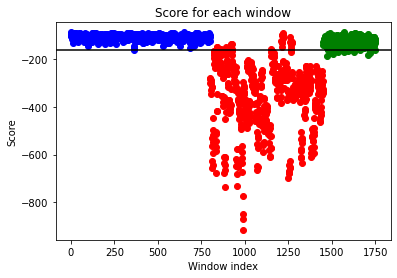

In [13]:
#show all window scores result - represent likelihood of each scenario
ok_window_index = np.arange(0, (len(ok_wave)-20)*augment_ratio)
ok_window_score = window_score[0:(len(ok_wave)-20)*augment_ratio]

ng_window_index = np.arange((len(ok_wave)-20)*augment_ratio,
                            (len(ng_wave)+len(ok_wave)-20)*augment_ratio)
ng_window_score = window_score[(len(ok_wave)-20)*augment_ratio:
                               (len(ng_wave)+len(ok_wave)-20)*augment_ratio]

fp_window_index = np.arange((len(ng_wave)+len(ok_wave)-20)*augment_ratio,
                            len(valid_wave)*augment_ratio)
fp_window_score = window_score[(len(ng_wave)+len(ok_wave)-20)*augment_ratio:
                               len(valid_wave)*augment_ratio]
fig, ax = plt.subplots()
ax.scatter(ok_window_index, ok_window_score, color = 'b')
ax.scatter(ng_window_index, ng_window_score, color = 'r')
ax.scatter(fp_window_index, fp_window_score, color = 'g')
ax.axhline(y = decision_dict['score_threshold'], color = 'black')
ax.set_xlabel('Window index')
ax.set_ylabel('Score')
ax.set_title('Score for each window')

Because we defined "OK" as 0 and "NG" as 1, meaning we set audio testing results that are pre-tested manually as "pass" status equal to 0 and audio testing results that are pre-tested manually as "fail" status equal to 1. The score threshold line represents a definition of the pass and fails results. The red dots that spread well below the threshold line represent the likelihood of the past result. Therefore, the lower the score of "NG" means, the higher the likelihood that this product will result in a failed quality control test.

In [14]:
#calculate 'NG' window proportion in each wave
#make the decision through all augmented windows
window_prediction = score_to_pred(window_score, decision_dict)

In [15]:
#de-augmentation for each wave
wave_proportion_threshold = 0.5  #define the 'NG' window proportion threshold
wave_proportion = window_prediction.reshape((-1, augment_ratio)).mean(axis=1)

Text(0.5, 1.0, 'NG proportion for each wave')

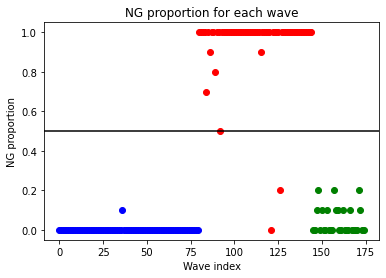

In [16]:
#show 'NG' window proportion in each wave
ok_wave_index = np.arange(0, len(ok_wave)-20)
ok_wave_proportion = wave_proportion[0:len(ok_wave)-20]
ng_wave_index = np.arange(len(ok_wave)-20, len(ng_wave)+len(ok_wave)-20)
ng_wave_proportion = wave_proportion[len(ok_wave)-20:
                                     len(ng_wave)+len(ok_wave)-20]
fp_wave_index = np.arange(len(ng_wave)+len(ok_wave)-20, len(valid_wave))
fp_wave_proportion = wave_proportion[len(ng_wave)+len(ok_wave)-20:
                                     len(valid_wave)]
fig, ax = plt.subplots()
ax.scatter(ok_wave_index, ok_wave_proportion, color = 'b')
ax.scatter(ng_wave_index, ng_wave_proportion, color = 'r')
ax.scatter(fp_wave_index, fp_wave_proportion, color = 'g')
ax.axhline(y = wave_proportion_threshold, color = 'black')
ax.set_xlabel('Wave index')
ax.set_ylabel('NG proportion')
ax.set_title('NG proportion for each wave')

The 295 files this model uses as a base show that the "OK" wave training result is statistically significant, where the model verified almost all results. 
On the other hand, the NG wave training result shows relatively significance where at least seven out of the 100 are not aligned with the supposed prediction from the model.

In [17]:
#Make final decision + display results
wave_prediction = (wave_proportion >= wave_proportion_threshold).astype(int)
ok_wave_prediction = wave_prediction[0:len(ok_wave)-20]
ng_wave_prediction = wave_prediction[len(ok_wave)-20:
                                     len(ng_wave)+len(ok_wave)-20]
fp_wave_prediction = wave_prediction[len(ng_wave)+len(ok_wave)-20:
                                     len(valid_wave)]
ok_wave_accuracy = (ok_wave_prediction == 0).mean()
ng_wave_accuracy = (ng_wave_prediction == 1).mean()
fp_wave_accuracy = (fp_wave_prediction == 0).mean()
print(f'OK accuracy: {ok_wave_accuracy}')
print(f'NG accuracy: {ng_wave_accuracy}')
print(f'FP accuracy: {fp_wave_accuracy}')

OK accuracy: 1.0
NG accuracy: 0.9692307692307692
FP accuracy: 1.0
